In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error


import warnings
warnings.filterwarnings("ignore")

%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


#  Прогнозирование временных рядов

### Стационарность

Под [стационарностью](https://ru.wikipedia.org/wiki/Стационарность) понимают свойство процесса не менять своих статистических характеристик с течением времени, а именно постоянство матожидания, постоянство дисперсии (она же гомоскедастичность) и независимость ковариационной функции от времени (должна зависеть только от расстояния между наблюдениями). Наглядно можно посмотреть на эти свойства на картинках, взятых из поста [Sean Abu](http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/):

- Случай 1: Временной ряд справа не является стационарным, так как его математическое ожидание со временем растёт

<img src="https://habrastorage.org/files/20c/9d8/a63/20c9d8a633ec436f91dccd4aedcc6940.png"/>

- Случай 2: Временной ряд справа не является стационарным, так как разброс значений ряда существенно варьируется в зависимости от периода

<img src="https://habrastorage.org/files/b88/eec/a67/b88eeca676d642449cab135273fd5a95.png"/>

- Случай 3: На графике видно, что значения ряда внезапно становятся ближе друг ко другу, образуя некоторый кластер, а в результате получаем непостоянство ковариаций

<img src="https://habrastorage.org/files/2f6/1ee/cb2/2f61eecb20714352840748b826e38680.png"/>

Почему стационарность так важна? По стационарному ряду просто строить прогноз, так как мы полагаем, что его будущие статистические характеристики не будут отличаться от наблюдаемых текущих. Большинство моделей временных рядов так или иначе моделируют и предсказывают эти характеристики (например, матожидание или дисперсию), поэтому в случае нестационарности исходного ряда предсказания окажутся неверными. К сожалению, большинство временных рядов, с которыми приходится сталкиваться, стационарными не являются, но с этим можно (и нужно) бороться.

Продемонстрируем как [белый шум превращается в случайное блуждание](https://mlcourse.ai/book/topic09/topic9_part1_time_series_python.html#topic09-part1). Попробуем сгенерировать  авторегрессии из семейства: 
$$y_t = \beta y_{t-1} + u_t$$ 
и проверить на стационарность моделируемые ими временные ряды

In [3]:
np.random.seed(1)
def plotProcess(n_samples=1000, beta=0):
    y = u = np.random.normal(size=n_samples)
    for t in range(n_samples):
        y[t] = beta * y[t-1] + u[t]

    with plt.style.context('bmh'):  
        plt.figure(figsize=(10, 3))
        plt.plot(y)
        p_adf = round(adfuller(y)[1], 3)  #критерий Дики-Фуллера о стационарности
        plt.title(f"Beta: {beta}\n Dickey-Fuller p-value: {p_adf}")

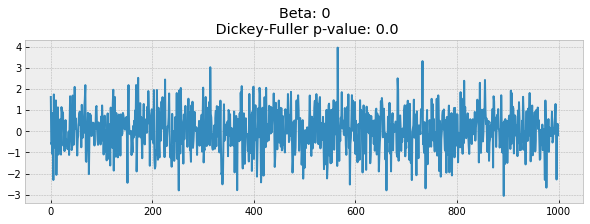

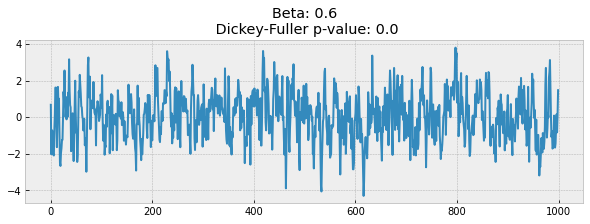

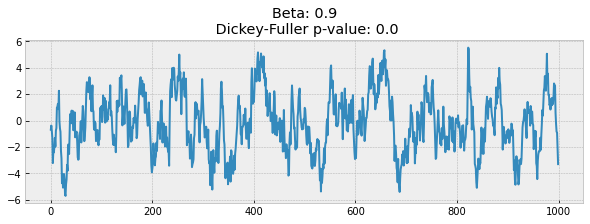

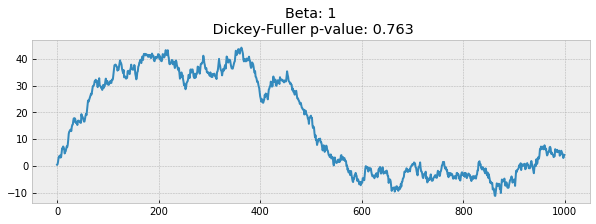

In [4]:
for beta in [0, 0.6, 0.9, 1]:
    plotProcess(beta=beta)

- На первом графике получился стационарный белый шум, последовательность из независимых нормальных случайных величин с нулевым математическим ожиданием и одинаковой дисперсией.
- На втором значение $\beta$ увеличилось до $0.6$, в результате чего на графике стали появляться более широкие циклы, но в целом стационарным он быть пока не перестал. 
- Третий график всё сильнее отклоняется от нулевого среднего значения, но всё ещё колеблется вокруг него. 
- Наконец, значение  равное единице дало процесс случайного блуждания — ряд не стационарен. Для него характеристики зависят от времени и мы подолгу задерживаемся по какую-то конкретную сторону от нуля. 

**Тест Дики-Фуллера**:

 $H_0\colon$ ряд не стационарен
 
 $H_1\colon$ ряд стационарен


Нулевая гипотеза [теста Дики-Фуллера](https://ru.wikipedia.org/wiki/Тест_Дики_—_Фуллера), отвергается на первых трех графиках, и не отвергается на последнем. 

### STL-декомпозиция ряда

[A Seasonal-Trend Decomposition Procedure Based on Loess](http://www.wessa.net/download/stl.pdf) - это процедура декомпозиции временного ряда на сезонную, трендовую составляющие и на остатки, использующую метод локальных регрессий (LOESS)

**Тренд** — долгосрочное изменение уровня ряда.

**Сезонность** — циклические изменения уровня ряда с постоянным периодом.

**Случайные колебания** — непрогнозируемое случайное изменение ряда.

**Ограничение.** STL-декомпозициию ряда целесообразно проводить только для аддитивных моделей $y_i = t_i + s_i + e_i$. Ряд содержит только одну сезонная компоненту и одну компоненту тренда. Ряд содержит как минимум два периода сезонности.

##  Задание 1. Анализ STL-декомпозиции

In [5]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:blue')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

Загрузим несколько наборов данных и проведем STL-декомпозиции этих рядов.

Для каждого набора данных ответьте на вопросы:
1. Является ли ряд станицонарным?
2. Имеется ли тренд?
3. Имеется ли сезонная компонента?
4. Стабильна ли дисперсия?
5. Остатки распределены однородно?

###  Ряд 1. Количество преступлений в России

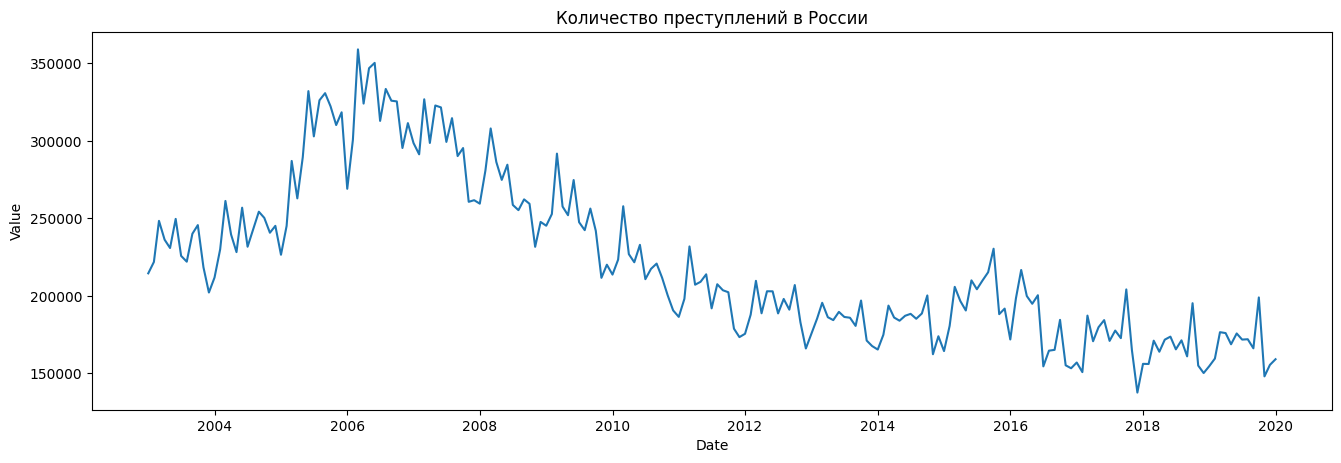

In [6]:
crime = pd.read_csv('crime.csv', index_col=['month'], parse_dates=['month'], dayfirst=True)
plot_df(crime, x=crime.index, y=crime.Total_crimes, title='Количество преступлений в России')

<Figure size 720x504 with 0 Axes>

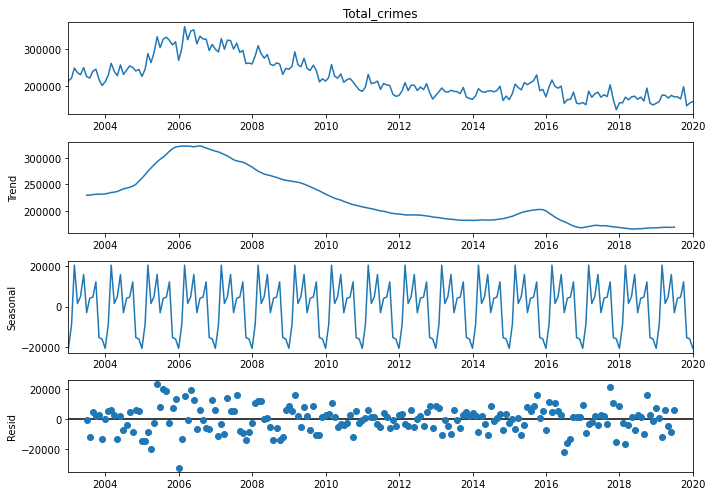

In [8]:
plt.figure(figsize(10,7))
sm.tsa.seasonal_decompose(crime.Total_crimes).plot()
plt.show()

###  Ряд 2. Солнечные пятна.

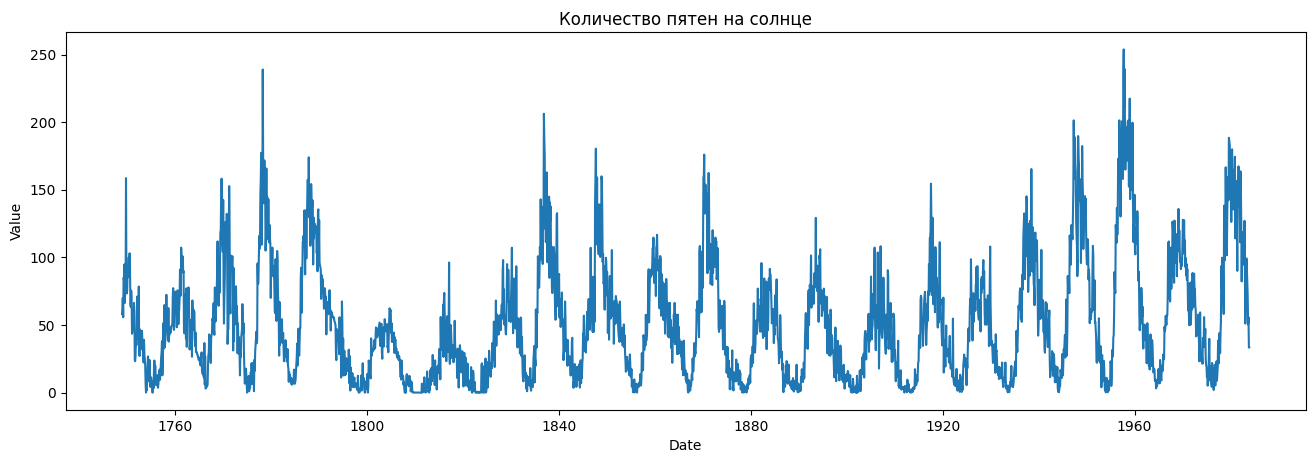

In [7]:
sunspots = pd.read_csv('monthly-sunspots.csv', index_col=['Month'], parse_dates=['Month'])
plot_df(sunspots, x=sunspots.index, y=sunspots.Sunspots, title='Количество пятен на солнце')

<Figure size 720x504 with 0 Axes>

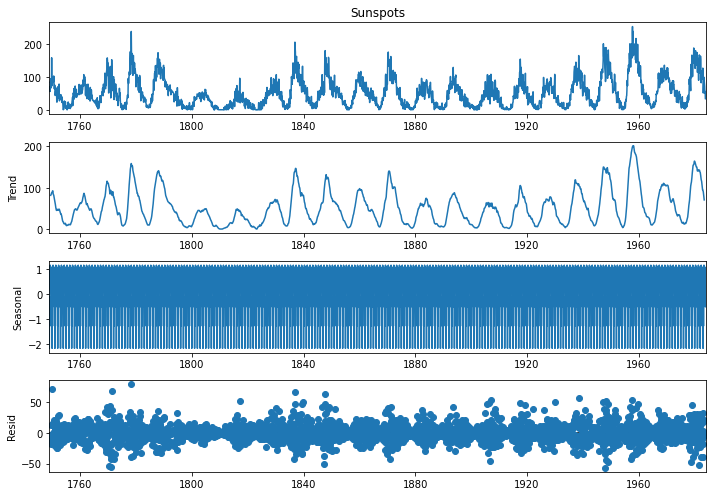

In [11]:
plt.figure(figsize(10,7))
sm.tsa.seasonal_decompose(sunspots.Sunspots).plot()
plt.show()

###  Ряд 3. Заболеваемость COVID-19 в России

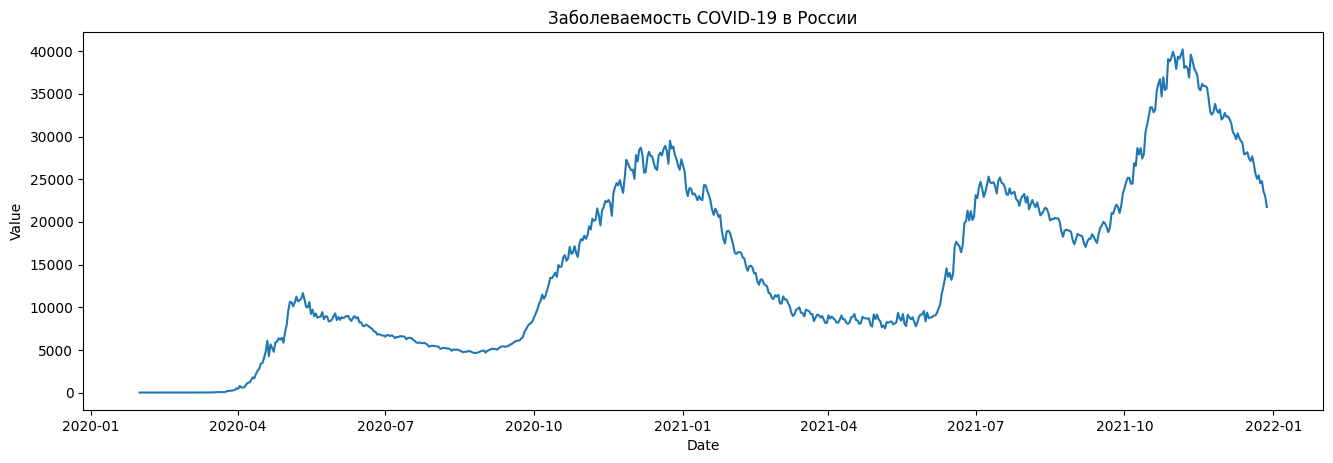

In [8]:
covid = pd.read_csv('covid.csv', index_col=['date'], parse_dates=['date'], dayfirst=True)
plot_df(covid, x=covid.index, y=covid.new_cases, title='Заболеваемость COVID-19 в России') 

<Figure size 720x504 with 0 Axes>

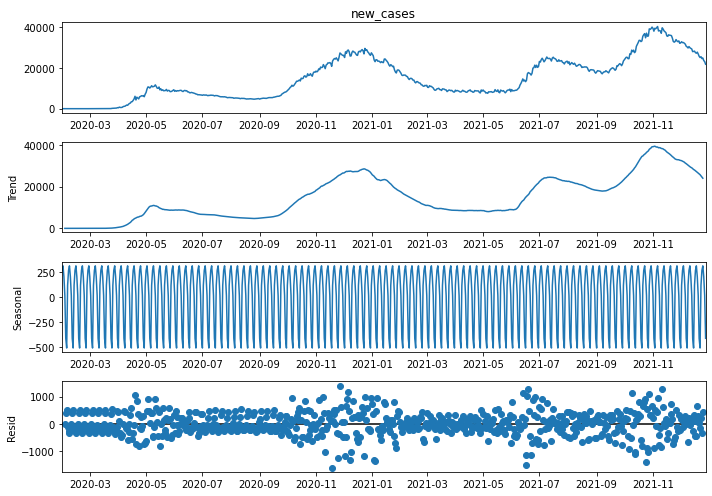

In [13]:
plt.figure(figsize(10,7))
sm.tsa.seasonal_decompose(covid.new_cases).plot()
plt.show()

###  Ряд 4. Средний онлайн Dota 2

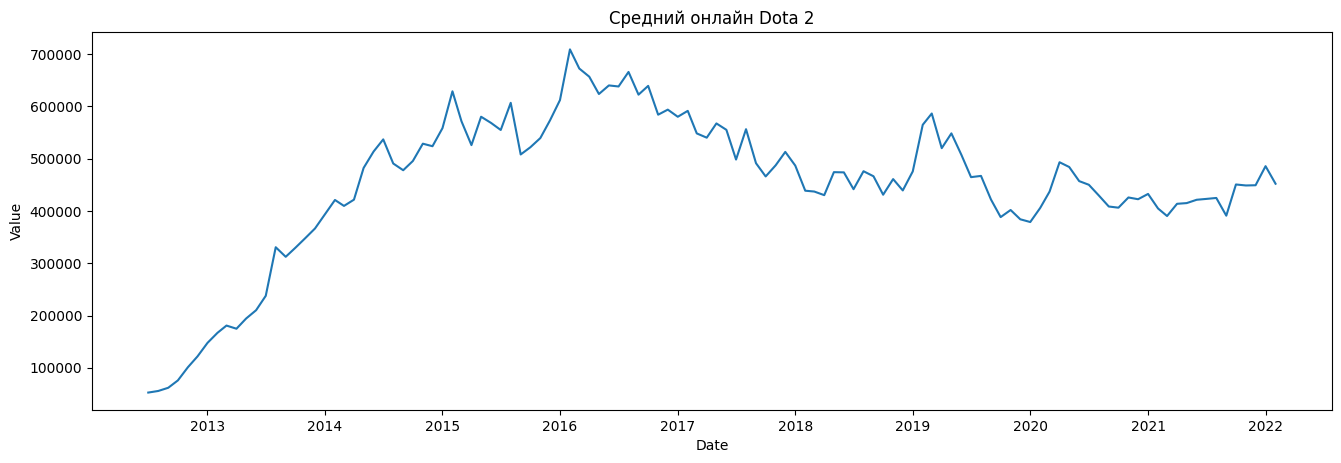

In [9]:
doka2 = pd.read_excel('Dota2.xlsx')
doka2.index = pd.to_datetime(doka2.Month)
plot_df(doka2, x=doka2.index, y=doka2.AvgPlayers, title='Средний онлайн Dota 2') 

<Figure size 720x504 with 0 Axes>

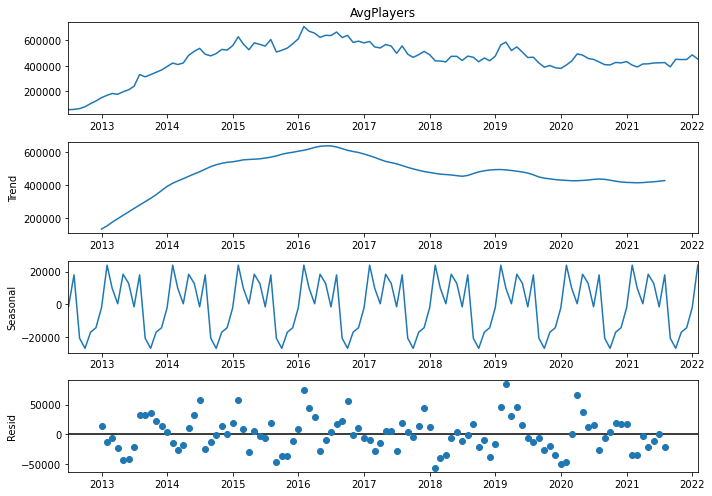

In [15]:
plt.figure(figsize(10,7))
sm.tsa.seasonal_decompose(doka2.AvgPlayers).plot()
plt.show()

##  Как еще выявить тренд? Или погладь кота, экспоненциально :0

Используя понятие скользящей средней можно проводить сглаживание исходного ряда для выявления трендов.

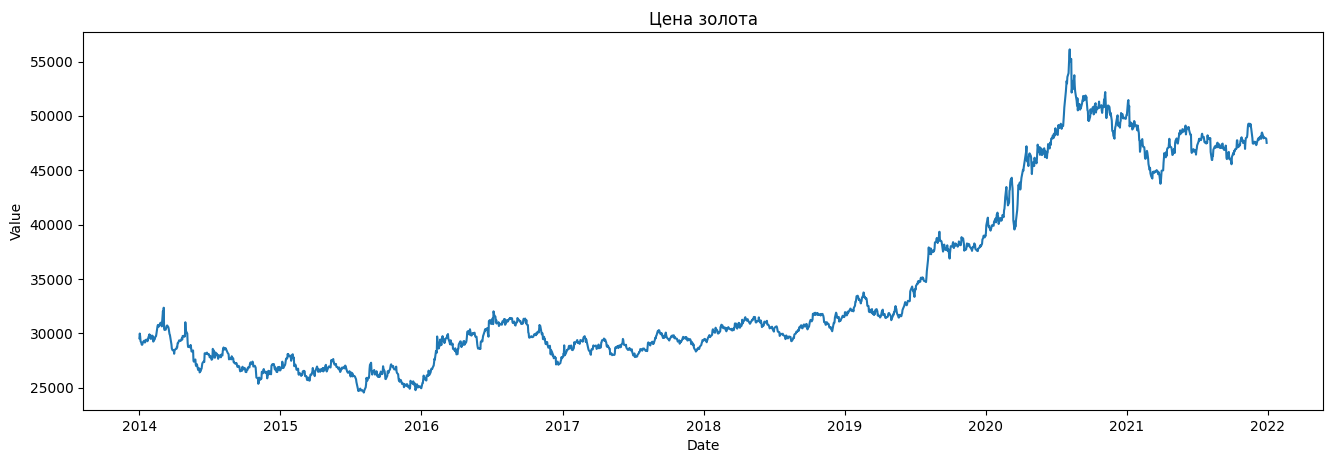

In [10]:
Gold = pd.read_csv('Gold Price.csv', parse_dates=['Date'], index_col='Date')
plot_df(Gold, x=Gold.index, y=Gold.Price, title='Цена золота')

<Figure size 720x504 with 0 Axes>

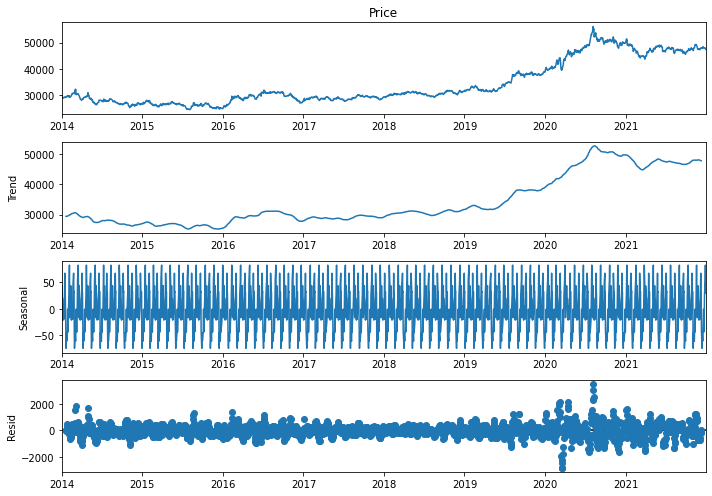

In [11]:
plt.figure(figsize(10,7))
sm.tsa.seasonal_decompose(Gold.Price, period=28).plot()
plt.show()

In [12]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'r', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'c--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'c--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)

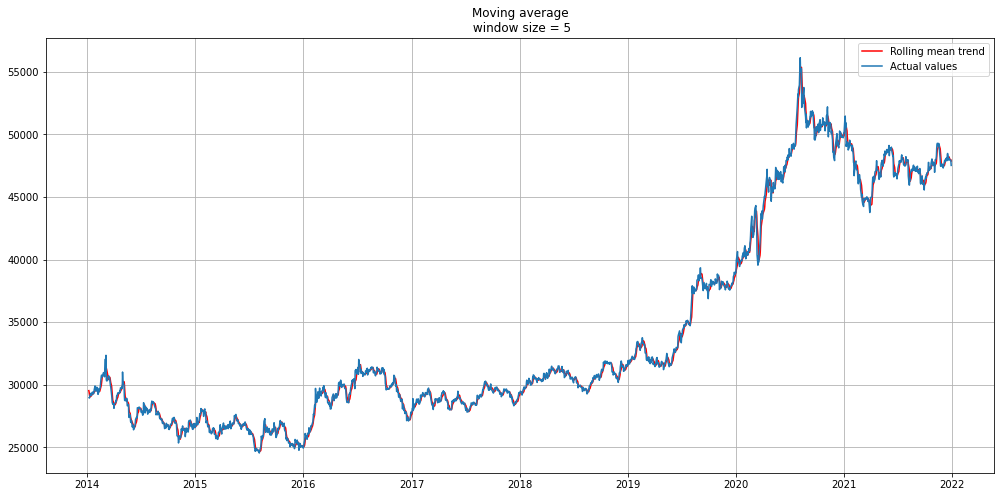

In [13]:
plot_moving_average(Gold.Price, 5)

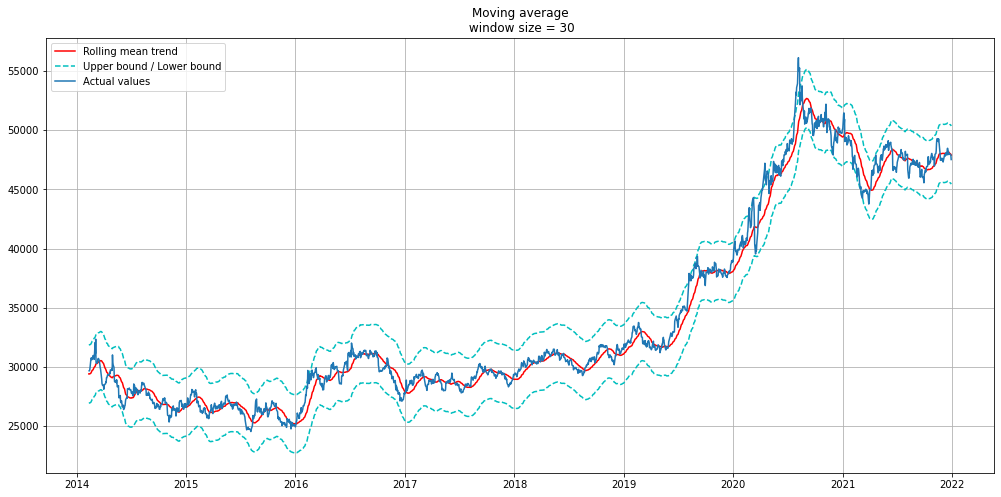

In [14]:
plot_moving_average(Gold.Price, 30, plot_intervals=True)

Развивая идею скользящего среднего можно перейти к взвешенному среднему, внутри которого наблюдениям придаются различные веса, в суме дающие единицу, при этом обычно последним наблюдениям присваивается больший вес. 
$$\hat{y}_{t} = \displaystyle\sum^{k}_{n=1} \omega_n y_{t+1-n}$$


Еще одним подходом является экспоненциальное сглаживание - вместо взвешивания последних $n$ значений ряда мы начнем взвешивать все доступные наблюдения, при этом экспоненциально уменьшая веса по мере углубления в исторические данные. В этом нам поможет формула простого [экспоненциального сглаживания](http://www.machinelearning.ru/wiki/index.php?title=Экспоненциальное_сглаживание):

$$\hat{y}_{t} = \alpha \cdot y_t + (1-\alpha) \cdot \hat y_{t-1} $$

Здесь модельное значение представляет собой средневзвешенную между текущим истинным и предыдущим модельным значениями. Вес $\alpha$ называется сглаживающим фактором. Он определяет, как быстро мы будем "забывать" последнее доступное истинное наблюдение. Чем меньше $\alpha$, тем больше влияния оказывают предыдущие модельные значения, и тем сильнее сглаживается ряд. 

Экспоненциальность скрывается в рекурсивности функции - каждый раз мы умножаем $(1-\alpha)$ на предыдущее модельное значение, которое, в свою очередь, также содержало в себе $(1-\alpha)$, и так до самого начала.

In [15]:
def exponential_smoothing(series, alpha):

    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

def plot_exponential_smoothing(series, alphas):
 
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha), linewidth=1)
    plt.plot(series.values, "b", label = "Actual", linewidth=0.8)
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True)

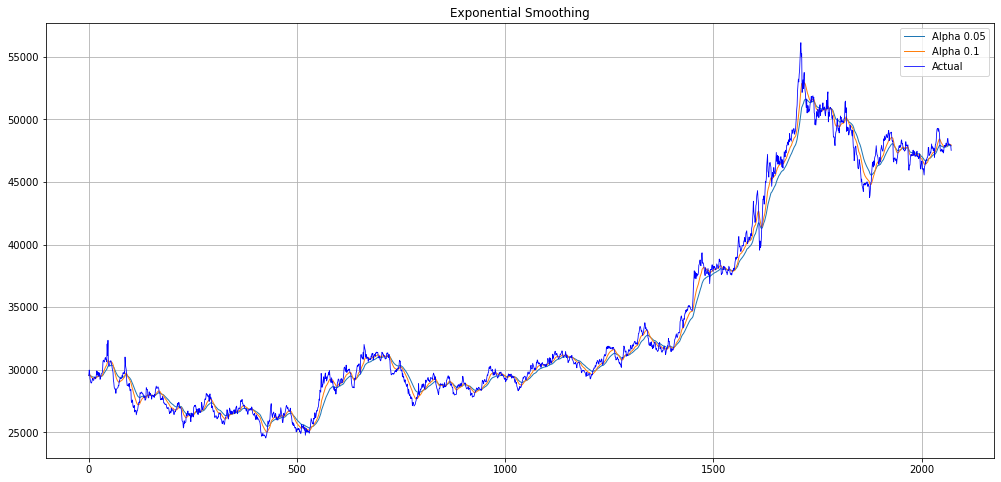

In [16]:
plot_exponential_smoothing(Gold.Price, [0.05, 0.1])

##  Задание 2. Прогнозирование количества преступлений в России

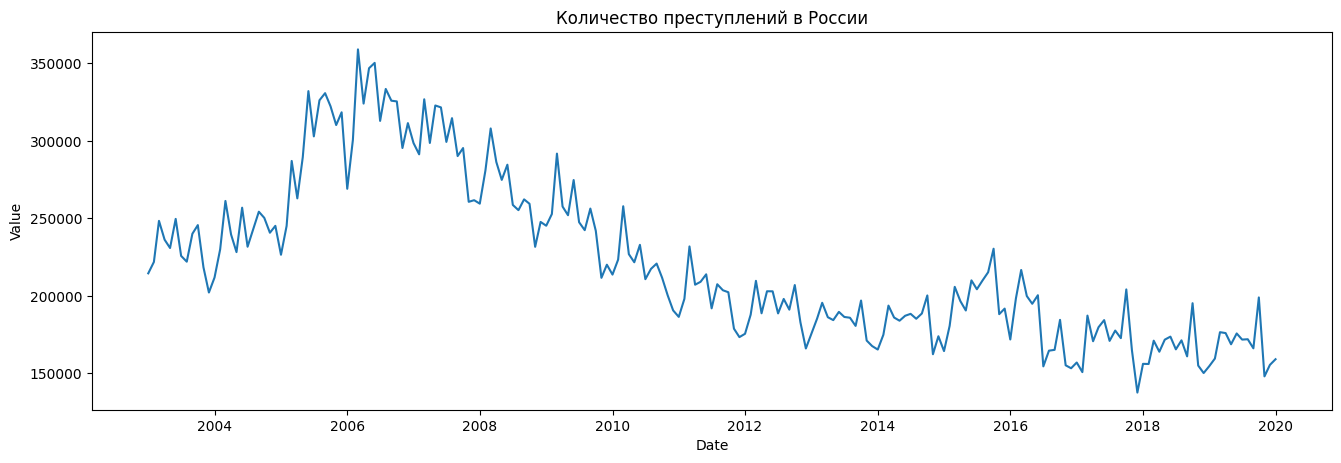

In [17]:
plot_df(crime, x=crime.index, y=crime.Total_crimes, title='Количество преступлений в России')

### Приведение к стационарному ряду на основе дифференцирования

Проведем сезонное $D=12$ дифференцирование:

<Figure size 720x504 with 0 Axes>

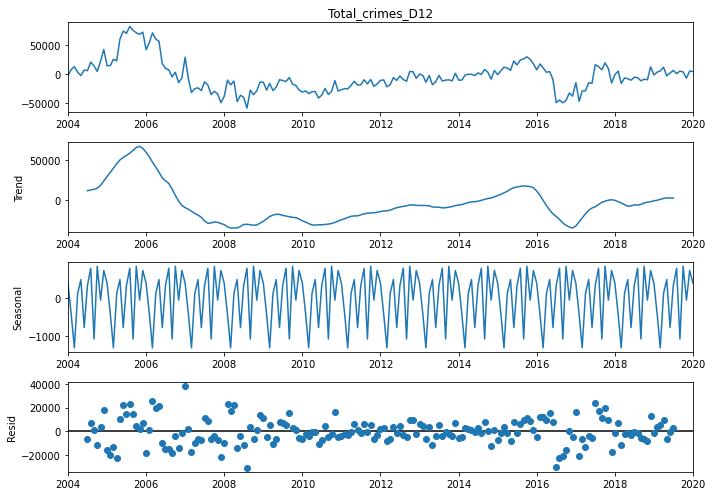

In [20]:
crime['Total_crimes_D12'] = crime.Total_crimes - crime.Total_crimes.shift(12)
plt.figure(figsize(10,7))
sm.tsa.seasonal_decompose(crime.Total_crimes_D12[12:]).plot()
plt.show()

In [21]:
print('Критерий Дики-Фуллера с константой =', round(adfuller(crime.Total_crimes_D12[12:])[1], 4))

Критерий Дики-Фуллера с константой = 0.2786


Проведем $d=1$ дифференцирование

<Figure size 720x504 with 0 Axes>

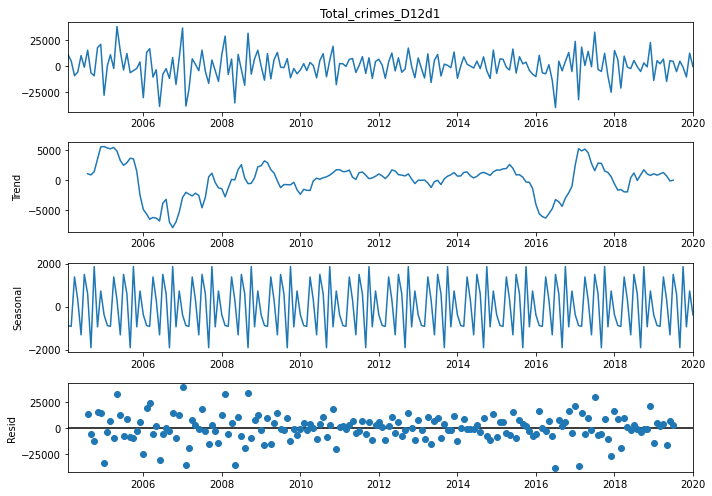

In [22]:
crime['Total_crimes_D12d1'] = crime.Total_crimes_D12 - crime.Total_crimes_D12.shift(1)
plt.figure(figsize(10,7))
sm.tsa.seasonal_decompose(crime.Total_crimes_D12d1[13:]).plot()
plt.show()

In [23]:
print('Критерий Дики-Фуллера с константой =', round(adfuller(crime.Total_crimes_D12d1[13:])[1], 4))

Критерий Дики-Фуллера с константой = 0.0


### Подбор параметров для ARIMA

Построим автокорреляционную функцию для определения начальных приближений $q, Q$ и частичную автокорреляционную функцию для $p, P$

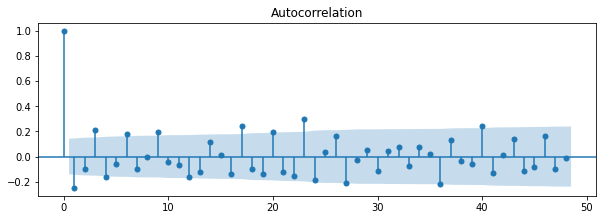

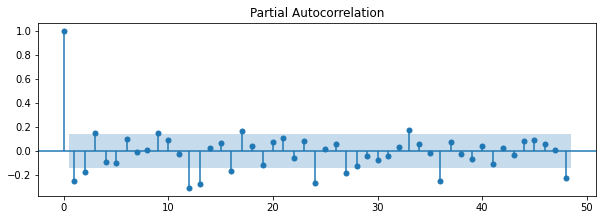

In [26]:
plt.figure(figsize(10, 7)) 
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(crime.Total_crimes_D12d1[13:].values.squeeze(), lags=48, ax=ax)
plt.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(crime.Total_crimes_D12d1[13:].values.squeeze(), lags=48, ax=ax)
plt.show()

1. $Q = 3$, так как 36 лаг является значимым
2. Максимальный значимый несезонный лаг равен 40, однако это слишком много, для упрощения модели ограничемся $q = 3$
3. Максимальный значимый сезонный лаг равен 48, значит $P = 4$
4. $p = 3$

In [27]:
D = 1
d = 1
Q = range(0, 4)
q = range(0, 4)
P = range(0, 5)
p = range(0, 4)
s = 12

In [28]:
from itertools import product
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print ("Количество рассматриваемых комбинаций параметров:", len(parameters_list))

Количество рассматриваемых комбинаций параметров: 320


In [33]:
from tqdm import tqdm_notebook
def optimize_SARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
    """
    
    results = []
    best_aic = float('inf')
    
    for param in tqdm_notebook(parameters_list):
        try: model = sm.tsa.statespace.SARIMAX(crime.Total_crimes, order=(param[0], d, param[1]),
                                               seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        
        #Save best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    #Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

result_table = optimize_SARIMA(parameters_list, d, D, s)

  0%|          | 0/320 [00:00<?, ?it/s]

In [34]:
result_table

,parameters,aic
0,"(2, 3, 0, 3)",4114.480310
1,"(3, 2, 0, 3)",4114.915432
2,"(2, 3, 3, 1)",4114.973823
3,"(3, 2, 3, 1)",4115.479644
4,"(2, 3, 1, 3)",4116.485632
...,...,...
315,"(0, 0, 0, 0)",4176.496698
316,"(0, 0, 1, 0)",4178.219774
317,"(0, 0, 2, 0)",4181.163988
318,"(0, 0, 0, 2)",4187.457509


In [29]:
p, q, P, Q = result_table.parameters[0]

best_model = sm.tsa.statespace.SARIMAX(crime.Total_crimes, order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)

print(best_model.summary())

NameError: name 'result_table' is not defined

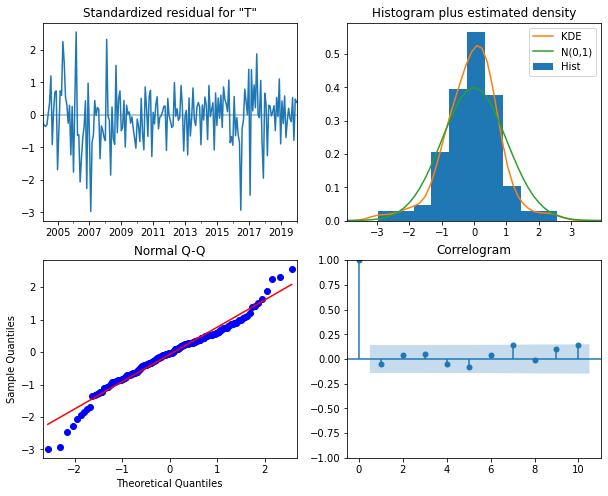

In [36]:
best_model.plot_diagnostics(figsize=(10, 8));

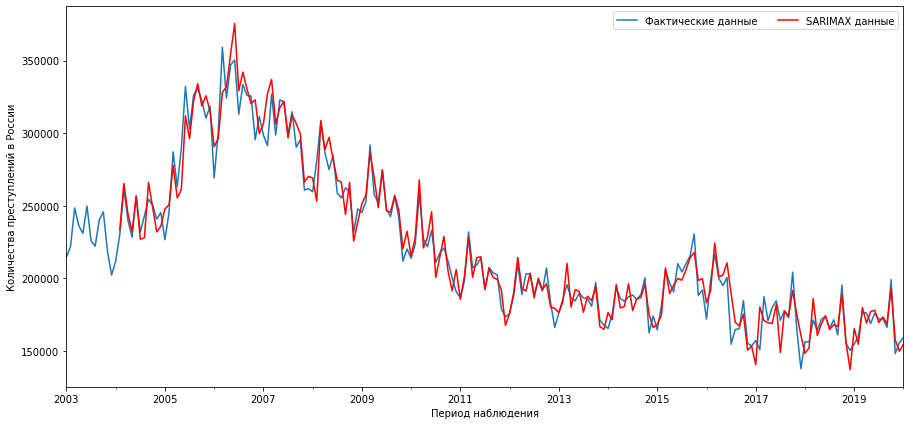

In [37]:
plt.figure(figsize(15,7))
plot1 = crime.Total_crimes.plot()
plot2 = best_model.fittedvalues[13:].plot(color='r')
plt.ylabel('Количества преступлений в России')
plt.xlabel('Период наблюдения')
plt.legend( ['Фактические данные', 'SARIMAX данные'], loc=1, ncol = 2, prop={'size':10})
plt.show()
warnings.filterwarnings('default')

Оценим среднюю абсолютную ошибку в процентах $MAPE = \frac{100}{n}\sum\limits_{i=1}^{n} \frac{|y_i - \hat{y}_i|}{y_i}$ 

In [30]:
def mape(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape(crime.Total_crimes[13:],  best_model.fittedvalues[13:])

NameError: name 'best_model' is not defined

Получим прогноз того, насколько опасно жить в России.

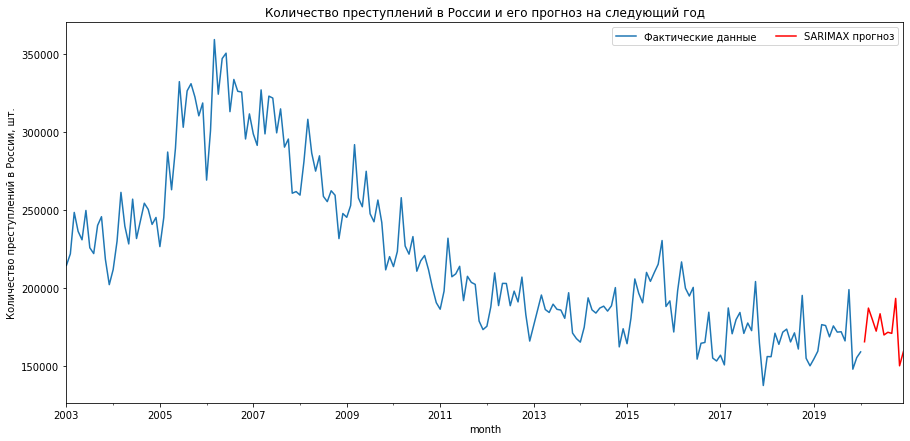

In [39]:
df2 = crime[['Total_crimes']]
date_list = [datetime.datetime.strptime("2020-01-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,12)]
future = pd.DataFrame(index=date_list)
df2 = pd.concat([df2, future])
df2['forecast'] = best_model.predict(start=crime.Total_crimes.shape[0], end=crime.Total_crimes.shape[0] + 12)

plt.figure(figsize(15,7))
crime['Total_crimes'].plot()
df2.forecast.plot(color='r')
plt.legend( ['Фактические данные', 'SARIMAX прогноз'], loc=1, ncol = 2, prop={'size':10})
plt.ylabel('Количество преступлений в России, шт.')
plt.title('Количество преступлений в России и его прогноз на следующий год')
pylab.show()